In [53]:
import os
import re
import json
import fnmatch
import warnings
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import signal, stats
from collections import defaultdict

plt.rcParams.update({'figure.max_open_warning': 0})
warnings.simplefilter("ignore")

%run /media/turritopsis/katie/grooming/t1-grooming/grooming_functions.ipynb
%matplotlib inline

sns.set()
sns.set_style('ticks')

In [69]:
titles = {
    'A_flex': 'coxa flexion',
    'A_abduct': 'body-coxa abduction',
    'A_rot': 'coxa rotation',
    'B_flex': 'coxa-femur flexion',
    'B_rot': 'femur rotation',
    'C_flex': 'femur-tibia flexion',
    'C_rot': 'tibia rotation',
    'D_flex': 'tibia-tarsus flexion',
    '_BC': 'body-coxa abduction'
}

temp_legend = {'0': '70-79',
               '1': '80-84',
               '2': '85-89'}

In [55]:
data_path = '/media/turritopsis/katie/apviz/classifiers/2021_04_26/temperature/training_data.parquet'

In [56]:
d = pd.read_parquet(data_path, engine='fastparquet')
d['date'] = d.flyid.str.partition(' ')[0]
data = d[d.behavior == 't1_grooming'] 
data['temp'] = data.flyid.str.partition('_')[2]

In [73]:
# add velocity and acceleration columns to data
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot', '_BC'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range', 'fictrac'])]

fps = 300.0 
dt = 1/fps
s = 1.0/dt
s2 = 1.0 / (dt * dt)
bout_numbers = np.unique(np.array(data.behavior_bout))

for j in range(len(bout_numbers)):
    mask = data.behavior_bout == bout_numbers[j]
    bout_df = data.loc[mask]
    for ang in angle_vars:
        bout = np.array(bout_df[ang])
        data.loc[mask, ang + '_d1'] = signal.savgol_filter(bout, 5, 3, deriv=1) * s
        data.loc[mask, ang + '_d2'] = signal.savgol_filter(bout, 5, 3, deriv=2) * s2

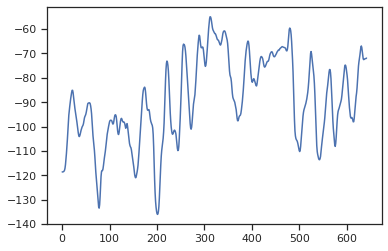

643


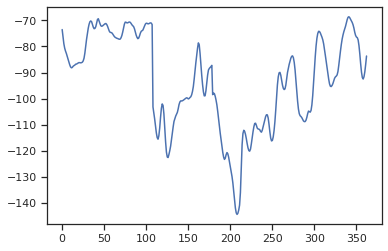

363


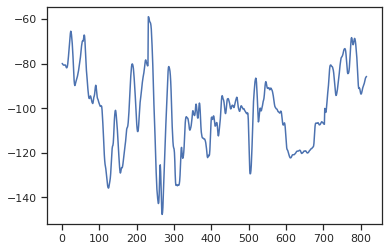

817


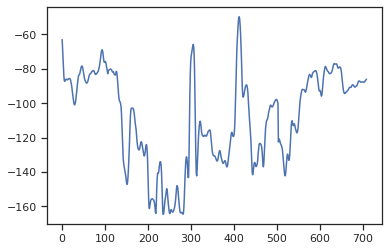

709


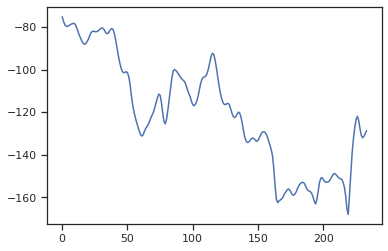

234


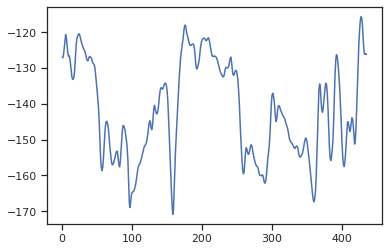

436


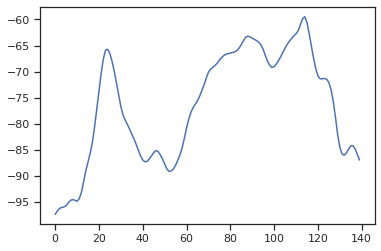

140


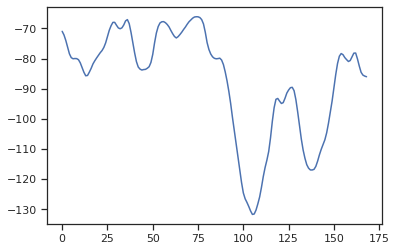

169


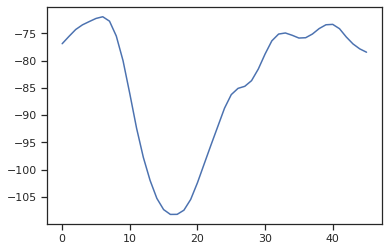

46


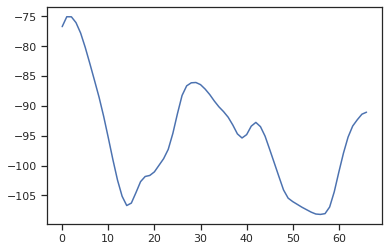

67


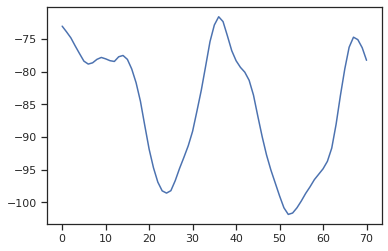

71


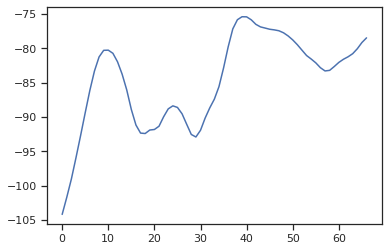

67


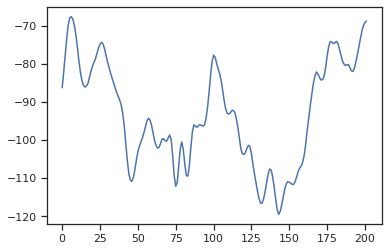

202


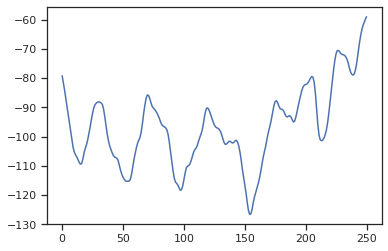

251


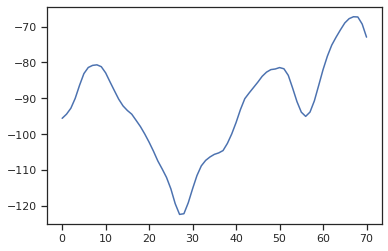

71


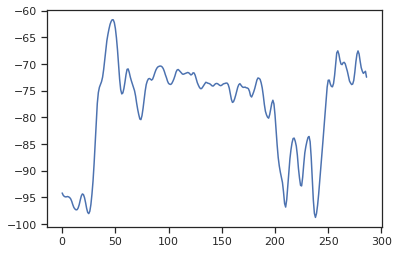

287


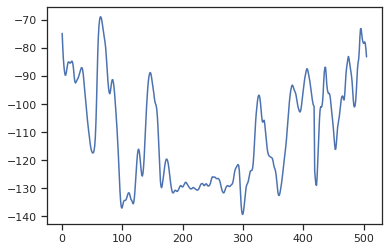

506


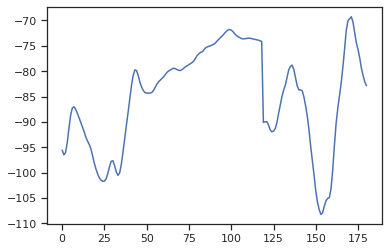

181


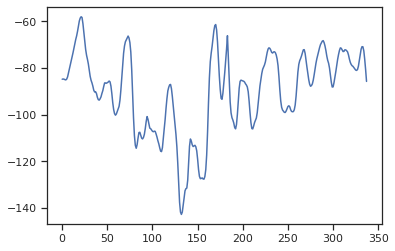

338


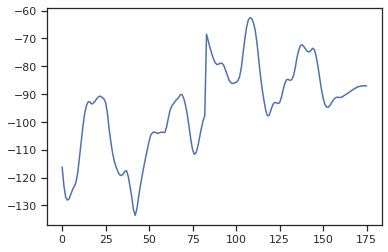

176


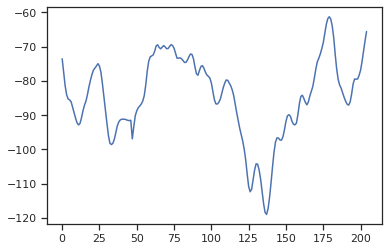

205


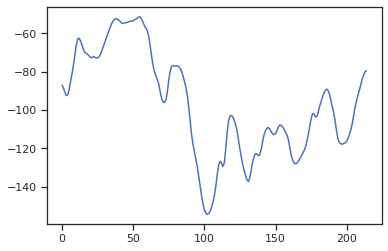

215


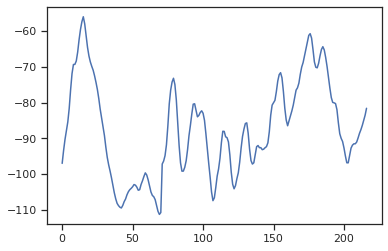

217


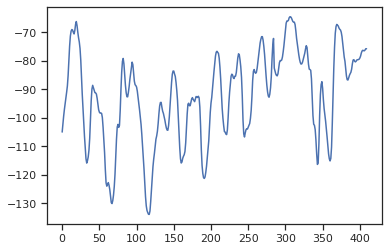

410


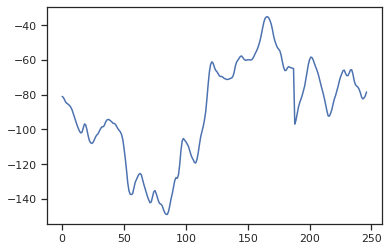

247


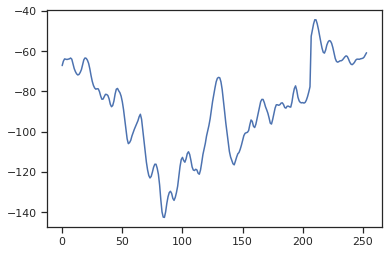

254


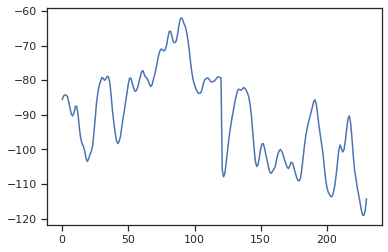

231


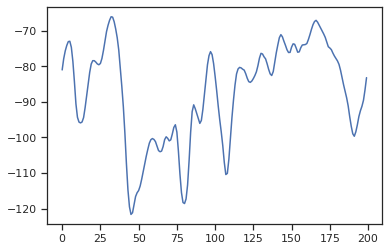

200


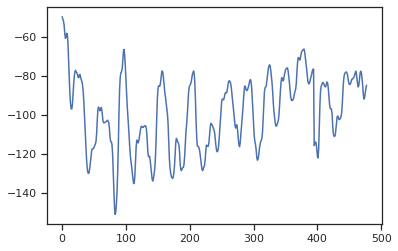

478


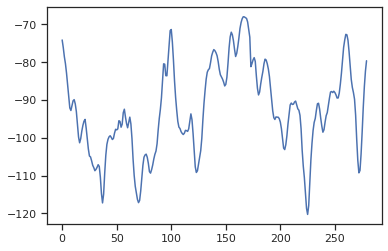

280


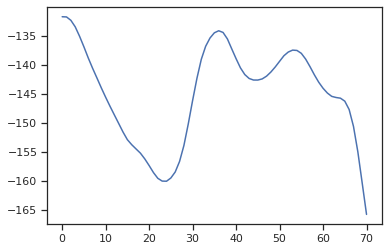

71


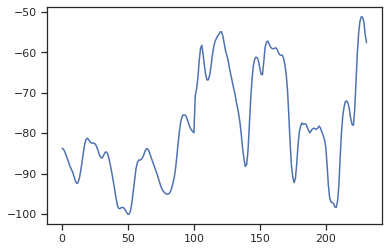

232


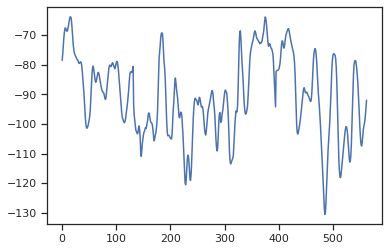

563


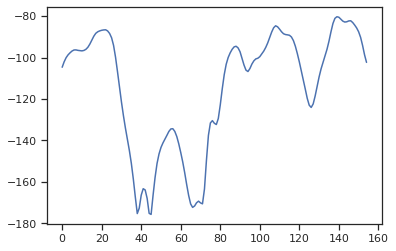

155


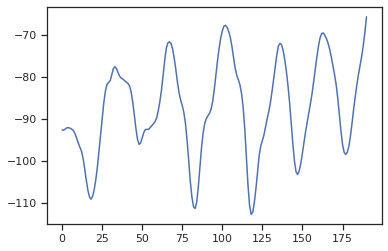

191


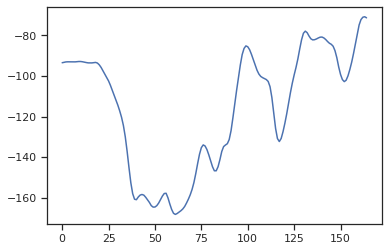

165


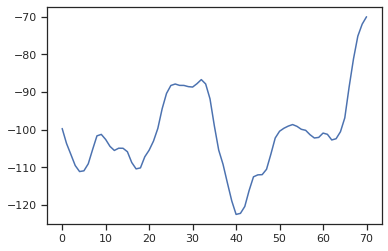

71


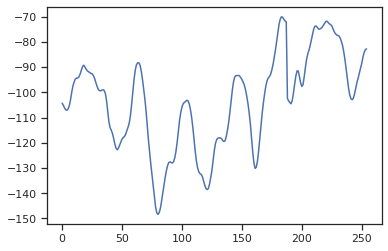

255


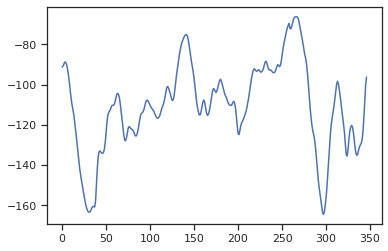

347


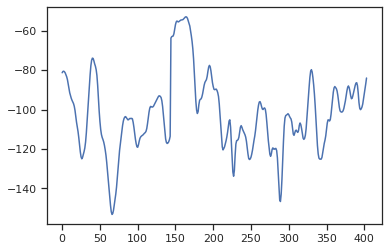

404


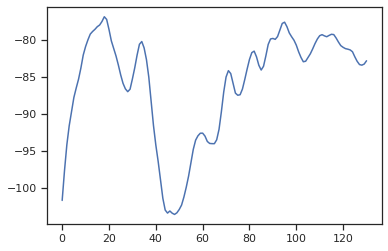

131


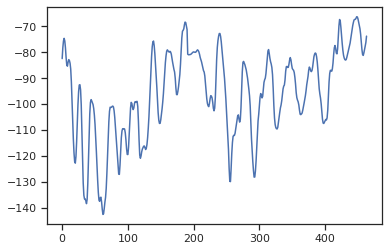

464


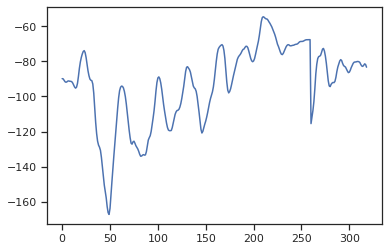

319


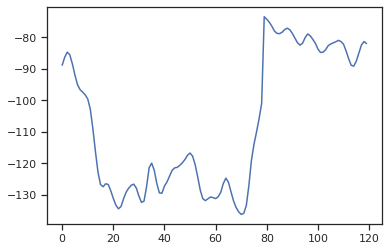

120


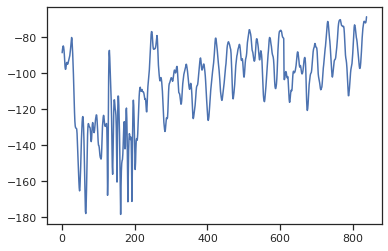

839


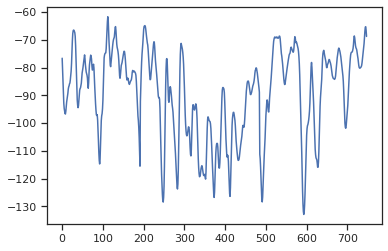

748


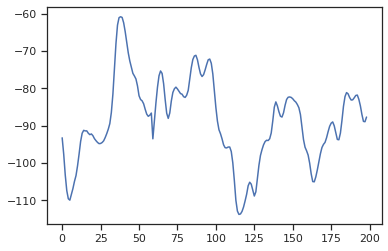

199


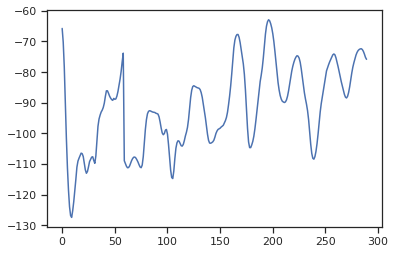

290


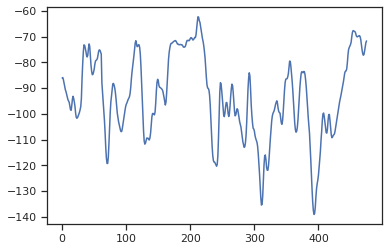

476


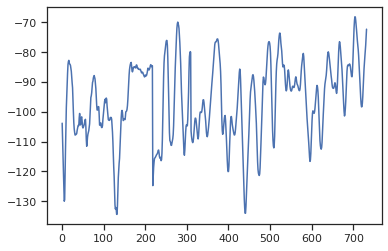

733


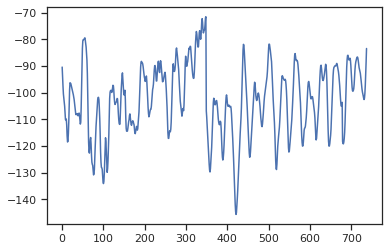

738


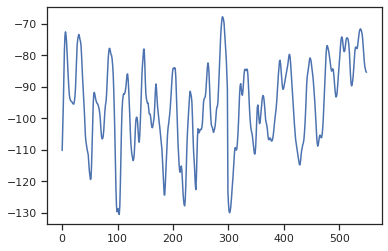

550


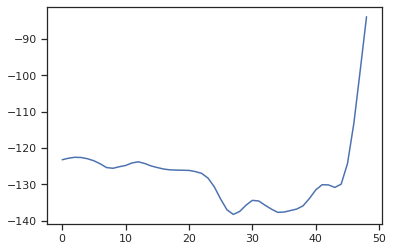

49


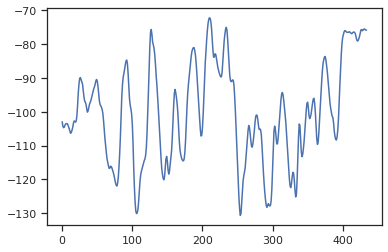

435


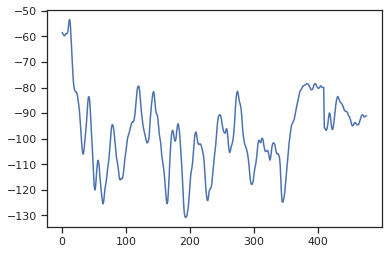

477


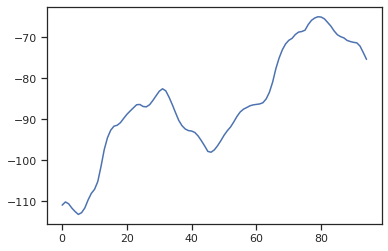

95


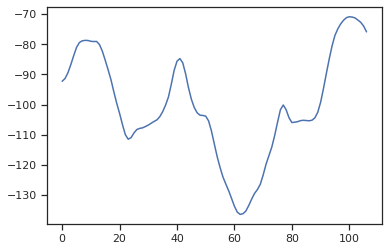

107


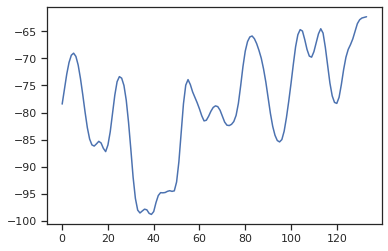

134


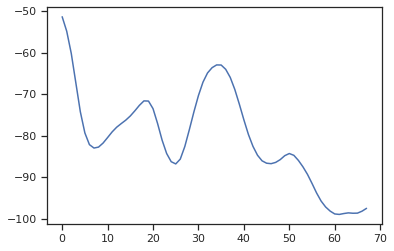

68


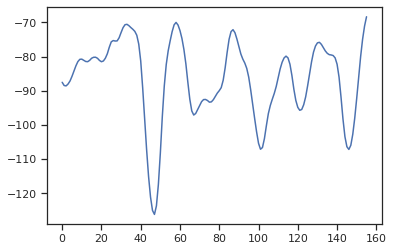

156


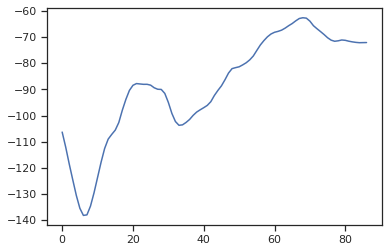

87


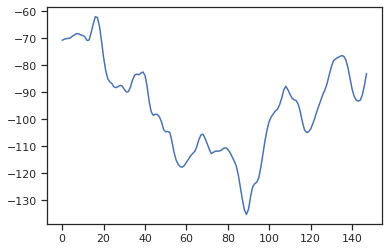

148


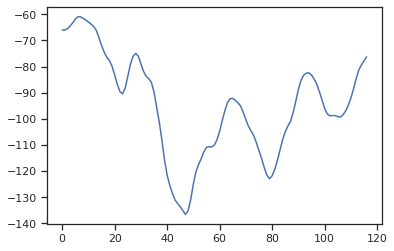

117


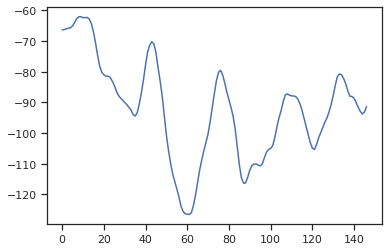

147


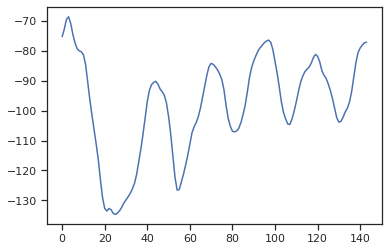

144


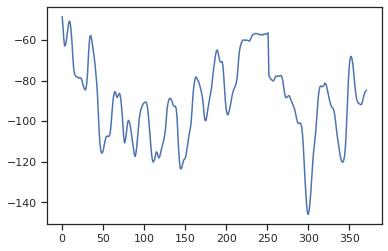

372


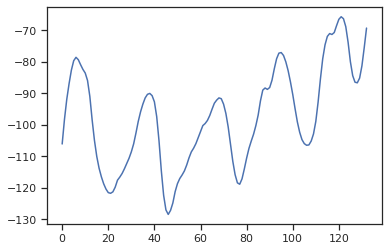

133


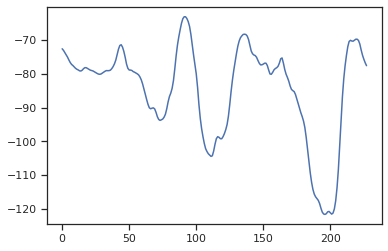

228


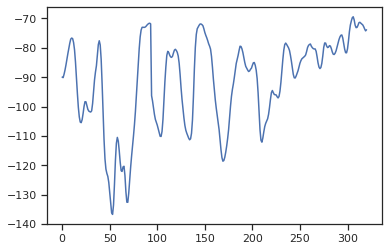

321


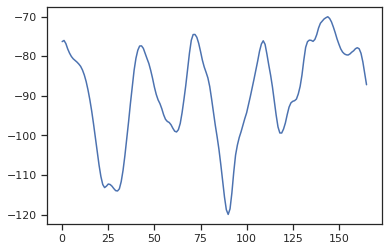

166


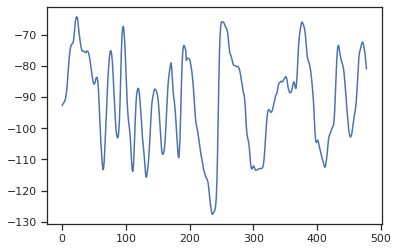

479


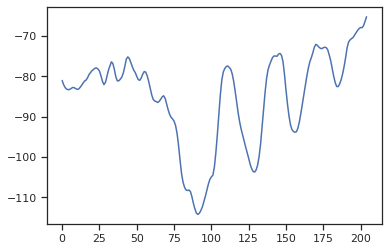

205


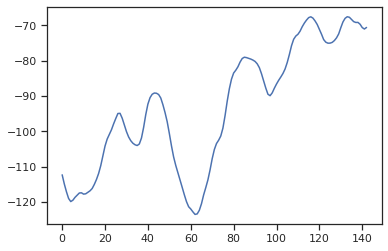

143


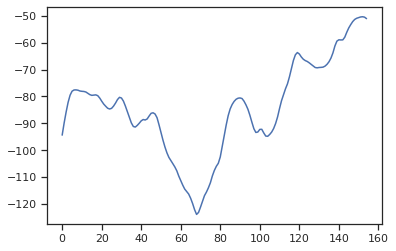

155


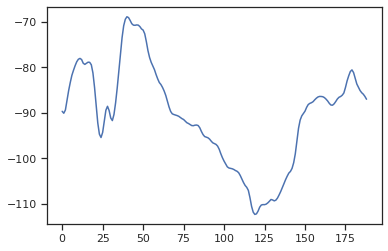

189


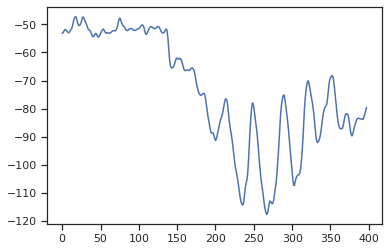

398


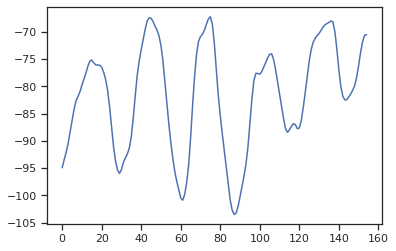

155


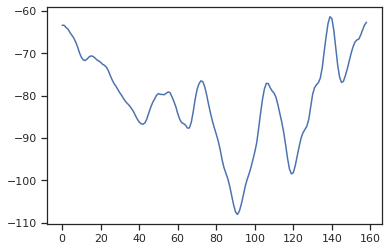

159


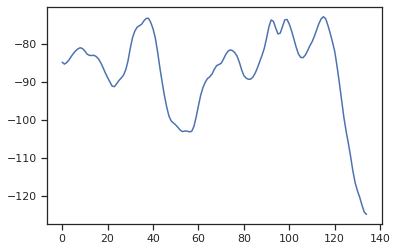

135


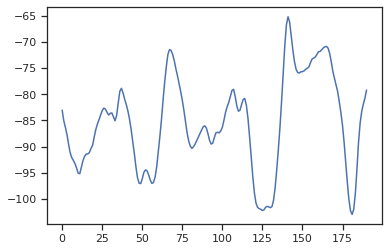

191


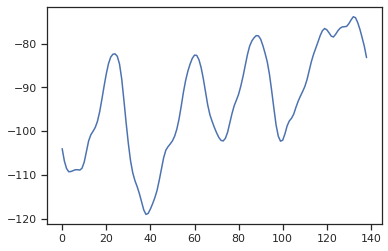

139


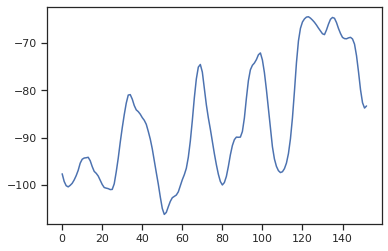

153


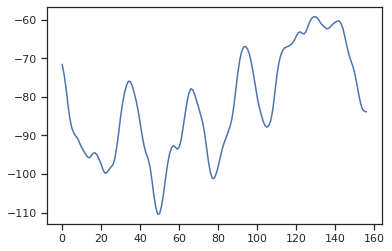

157


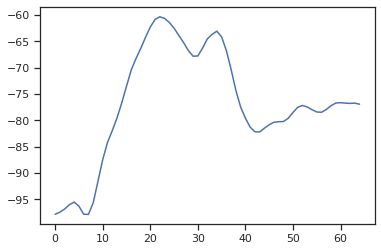

65


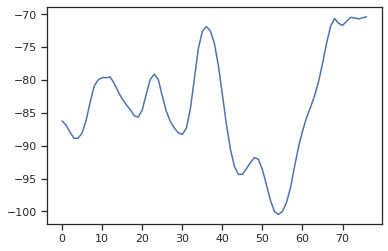

77


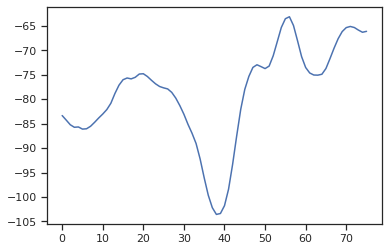

76


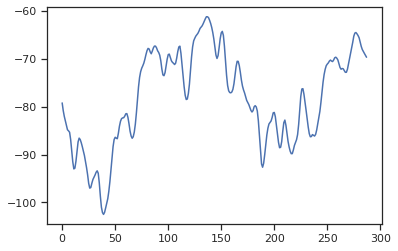

288


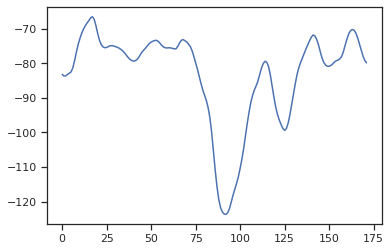

172


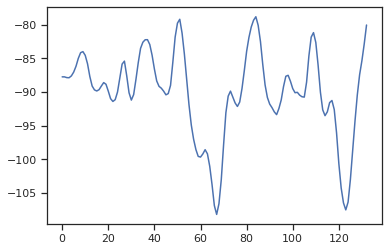

133


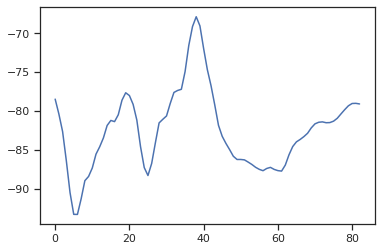

83


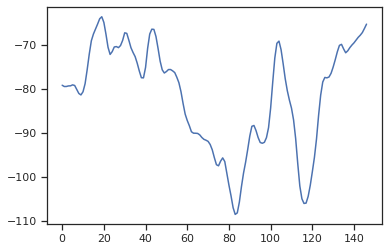

147


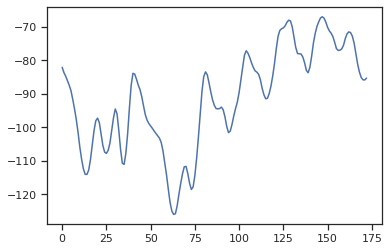

173


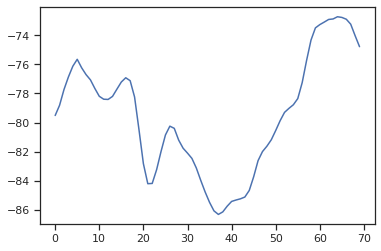

70


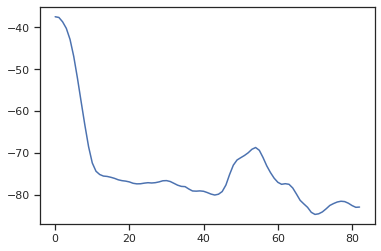

83


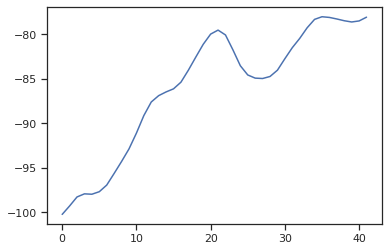

42


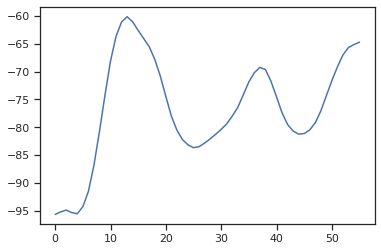

56


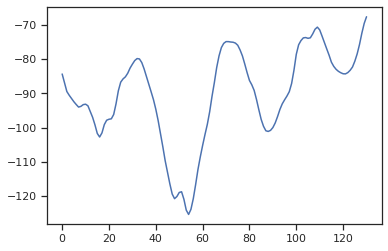

131


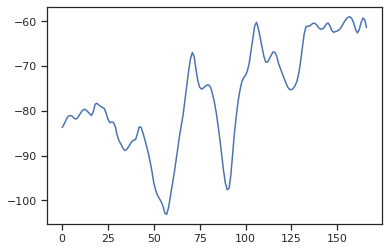

167


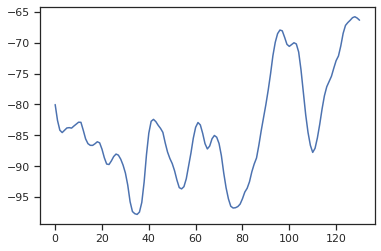

131


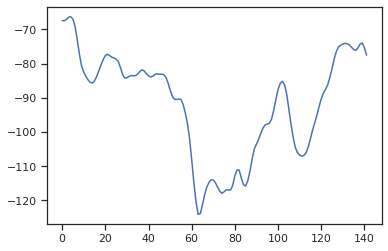

142


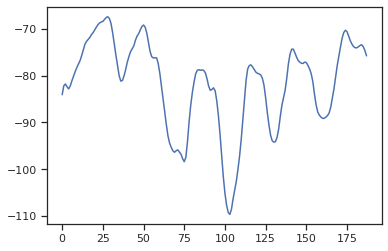

188


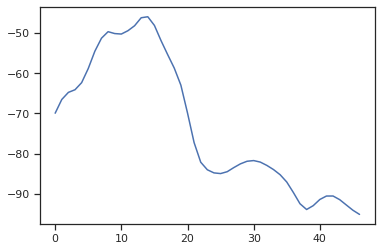

47


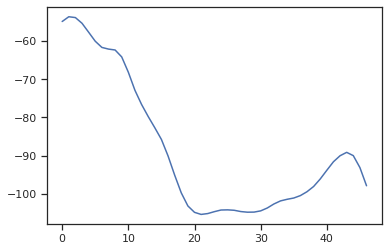

47


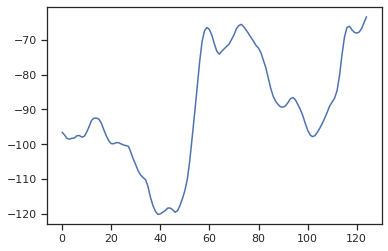

125


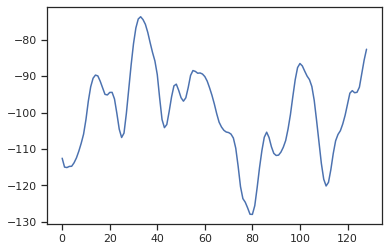

129


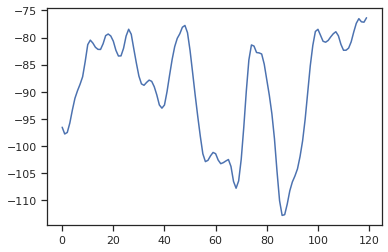

120


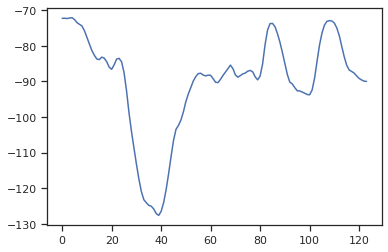

124


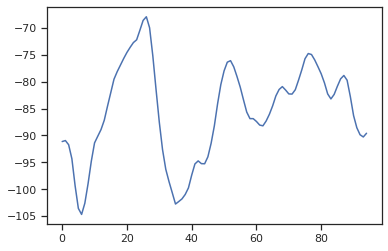

95


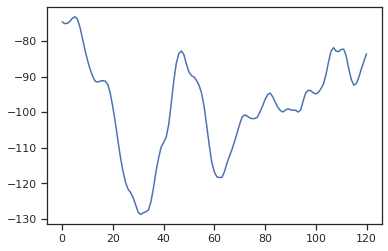

121


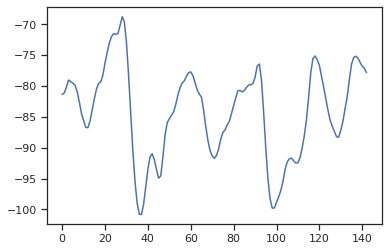

143


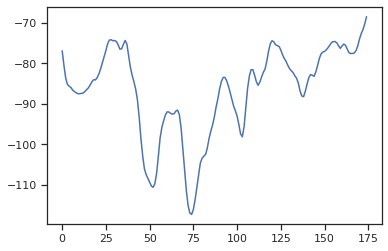

175


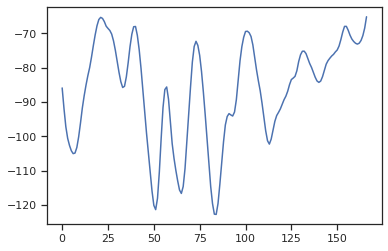

167


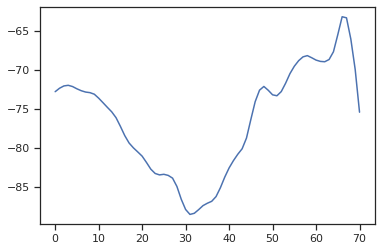

71


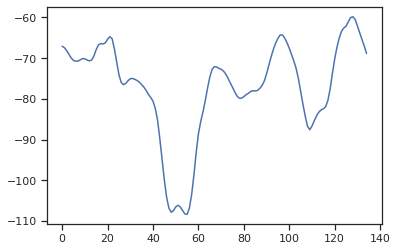

135


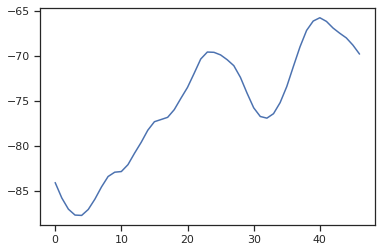

47


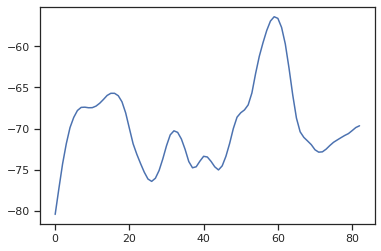

83


In [111]:
nframes = 0
for bout in bouts:
    fig = plt.figure()
    b = data[data.behavior_bout == bout]
    plt.plot(np.arange(len(b['L1C_flex'])), b['L1C_flex'])
    plt.show()
    print(len(b))
    nframes = nframes + len(b)

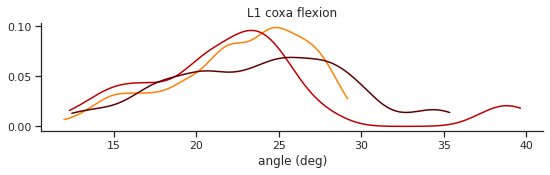

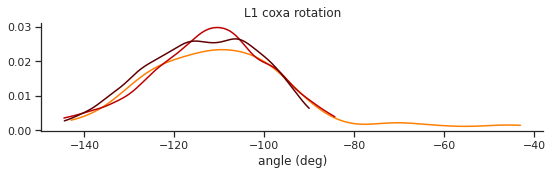

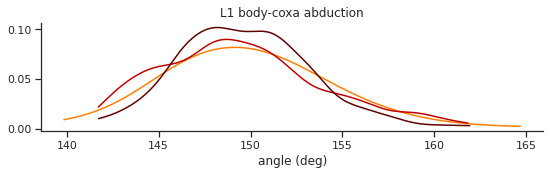

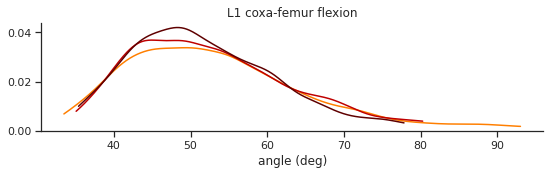

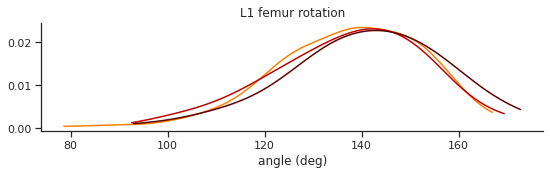

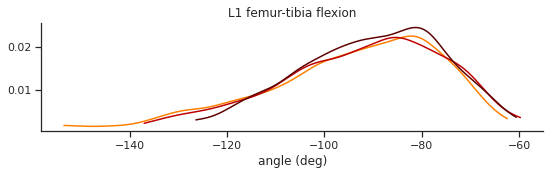

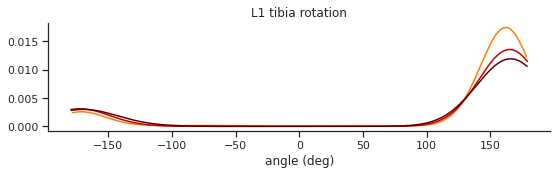

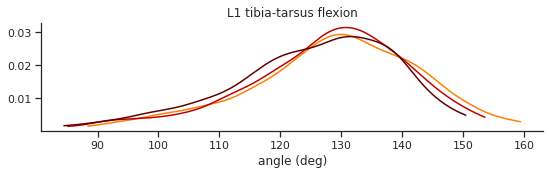

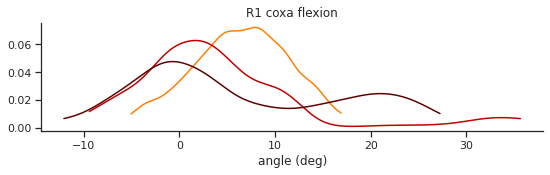

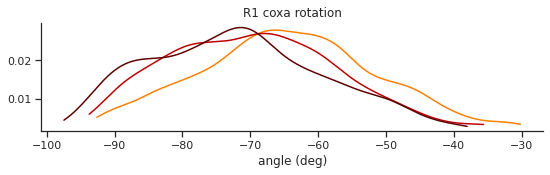

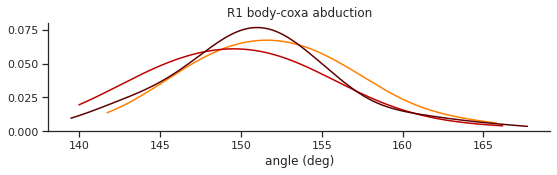

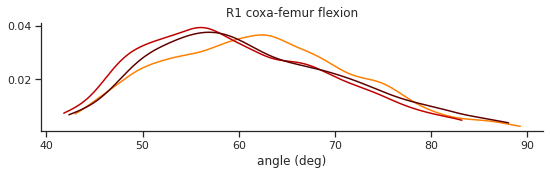

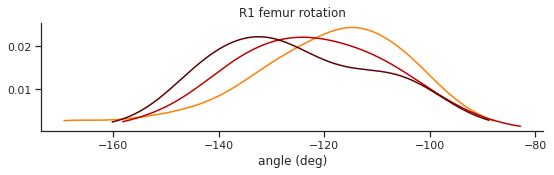

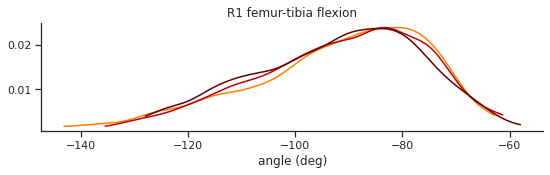

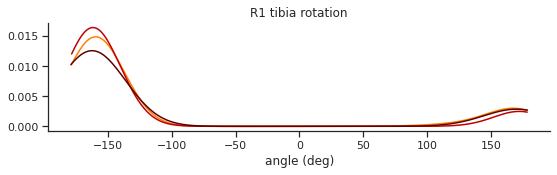

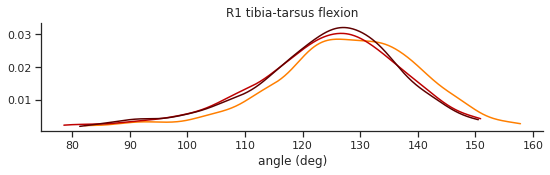

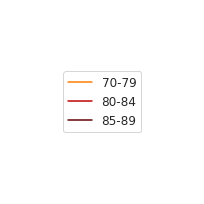

In [121]:
# plot angle distributions for each temperature treatment
sns.set_style('ticks')
temps = np.unique(data.temp)
legs = ['L1', 'R1']
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range', 'fictrac'])
              and v[:2] in legs]

for i in range(len(angle_vars)): 

    fig = plt.figure(figsize = (9,2))
    plt.title(angle_vars[i][:2] + ' ' + titles[angle_vars[i][2:]])
    plt.xlabel('angle (deg)')
    colors = sns.color_palette('gist_heat_r', len(temps))

    for j in range(len(temps)):

        temp_data = data[data['temp'] == temps[j]]

        t1 = temp_data.iloc[0:][angle_vars[i]]
        t1 = t1[np.isfinite(t1)] # ignores nans 
        if len(t1) <= 1: 
            continue        

        kernel_t1 = stats.gaussian_kde(t1)    
        t1 = np.linspace(np.percentile(t1, 2), np.percentile(t1, 98), 500)
        height_t1 = kernel_t1.pdf(t1)                       
        plt.plot(t1, height_t1, label = temp_legend[temps[j]], color = colors[j])
    
    ax = plt.gca()
    hs, ls = ax.get_legend_handles_labels()
    plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
    sns.despine()
    plt.show()

fig = plt.figure(figsize = (3,3))
plt.legend(handles = hs, labels = ls, loc = 'center', fontsize = 12)
plt.axis('off')
plt.tight_layout()
plt.show()   

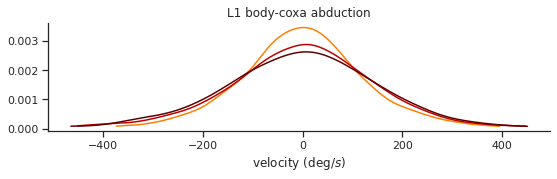

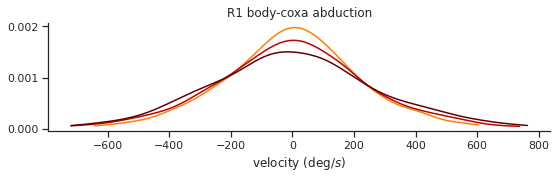

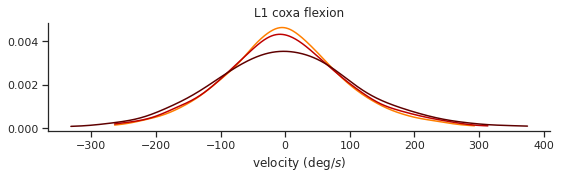

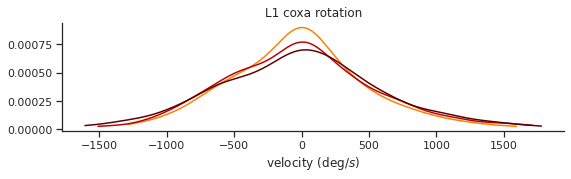

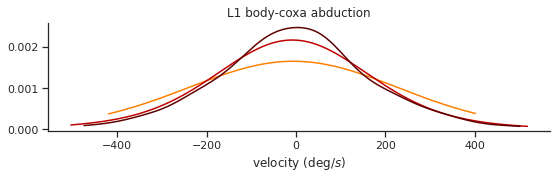

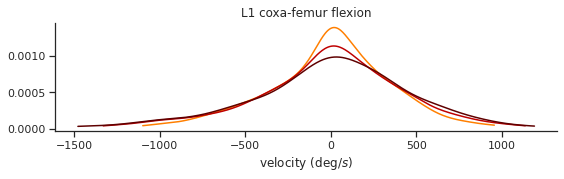

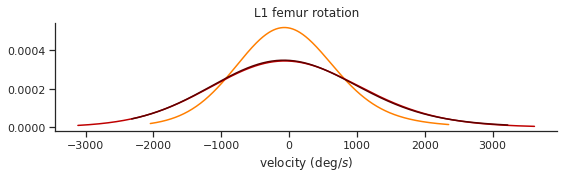

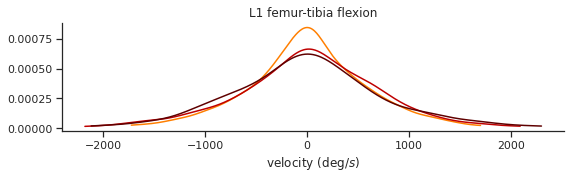

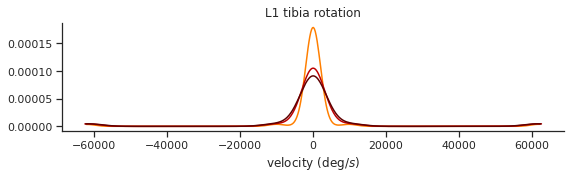

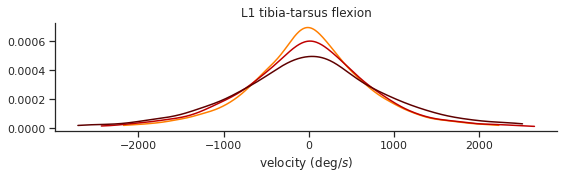

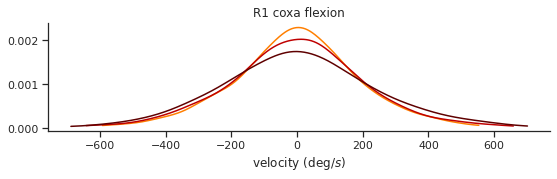

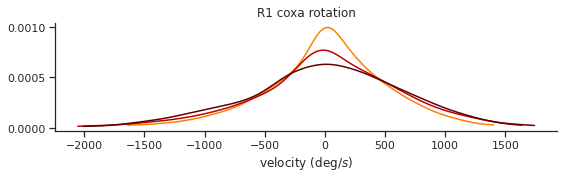

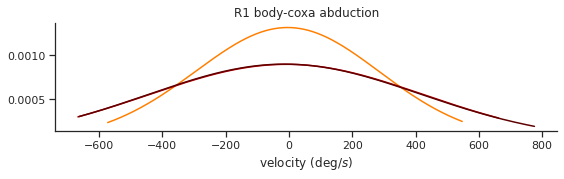

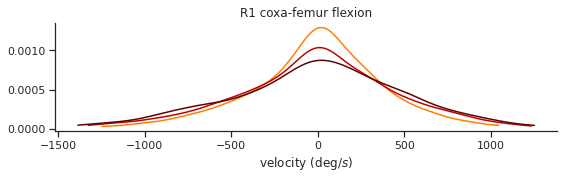

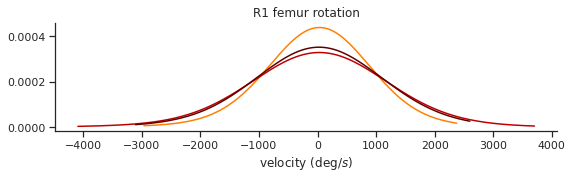

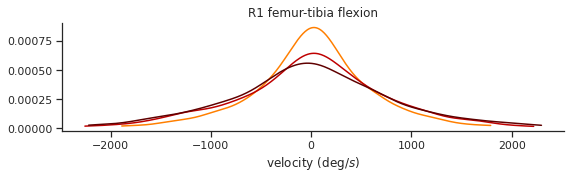

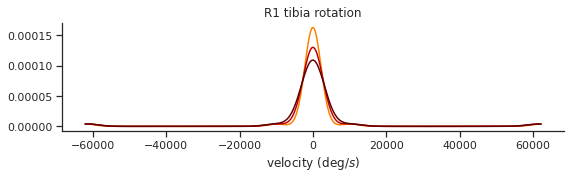

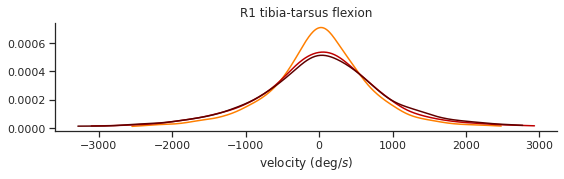

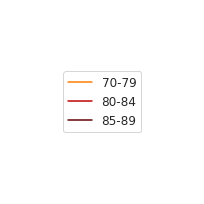

In [120]:
# plot angle distributions for each temperature treatment
sns.set_style('ticks')
temps = np.unique(data.temp)
legs = ['L1', 'R1']
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot', '_BC'])
              and some_contains(v, ['_d1'])
              and v[:2] in legs]

for i in range(len(angle_vars)): 

    fig = plt.figure(figsize = (9,2))
    plt.title(angle_vars[i][:2] + ' ' + titles[angle_vars[i][2:-3]])
    plt.xlabel('velocity (deg/$s$)')
    colors = sns.color_palette('gist_heat_r', len(temps))

    for j in range(len(temps)):

        temp_data = data[data['temp'] == temps[j]]

        t1 = temp_data.iloc[0:][angle_vars[i]]
        t1 = t1[np.isfinite(t1)] # ignores nans 
        if len(t1) <= 1: 
            continue        

        kernel_t1 = stats.gaussian_kde(t1)    
        t1 = np.linspace(np.percentile(t1, 1), np.percentile(t1, 99), 500)
        height_t1 = kernel_t1.pdf(t1)                       
        plt.plot(t1, height_t1, label = temp_legend[temps[j]], color = colors[j])
    
    ax = plt.gca()
    hs, ls = ax.get_legend_handles_labels()
    plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
    sns.despine()
    plt.show()

fig = plt.figure(figsize = (3,3))
plt.legend(handles = hs, labels = ls, loc = 'center', fontsize = 12)
plt.axis('off')
plt.tight_layout()
plt.show()   

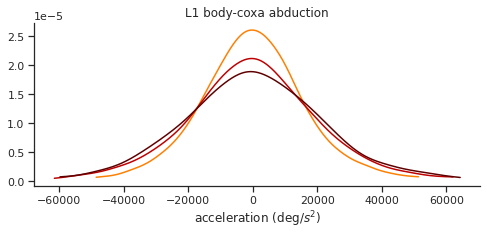

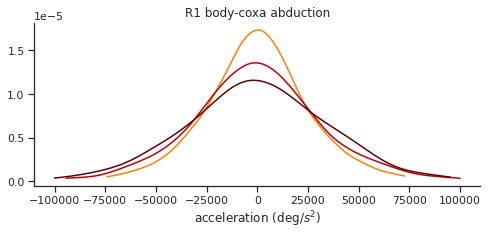

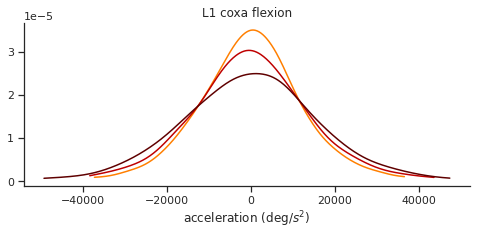

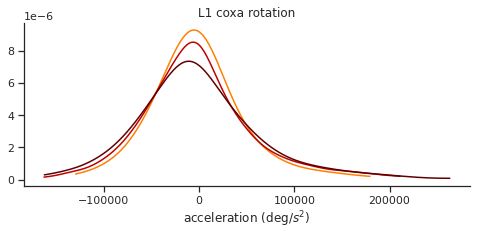

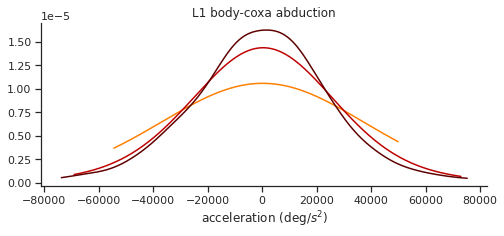

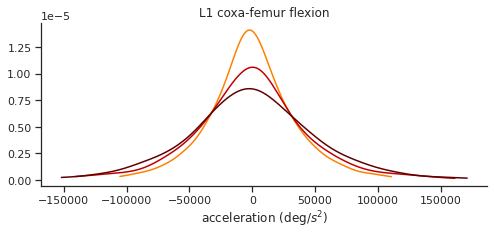

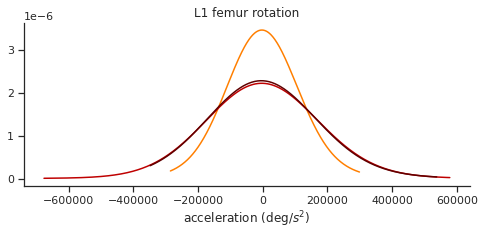

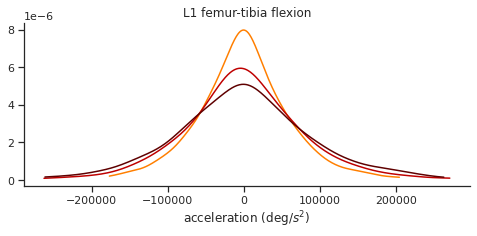

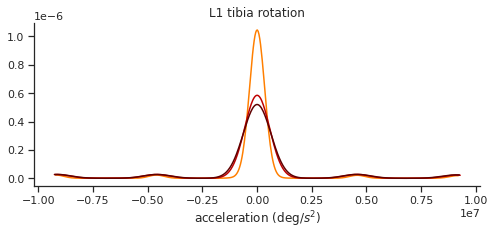

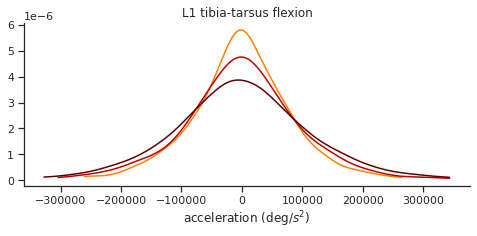

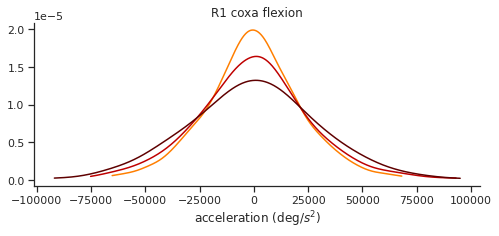

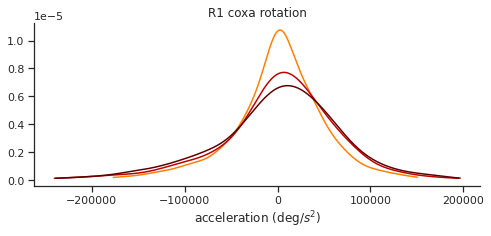

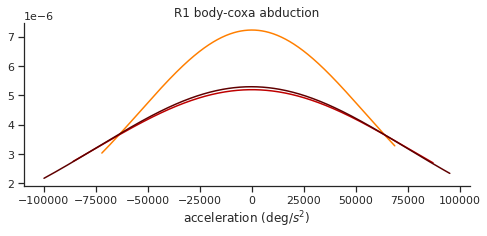

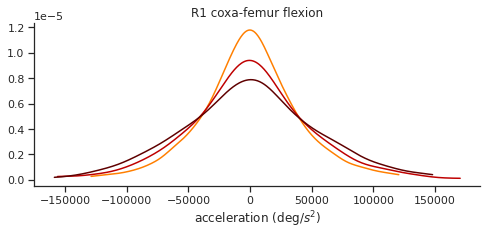

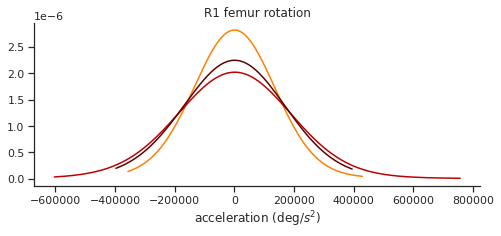

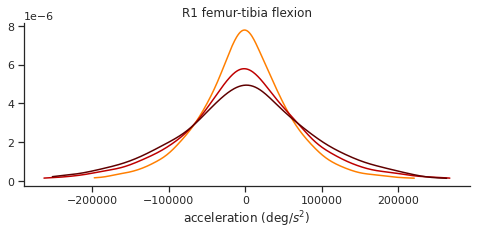

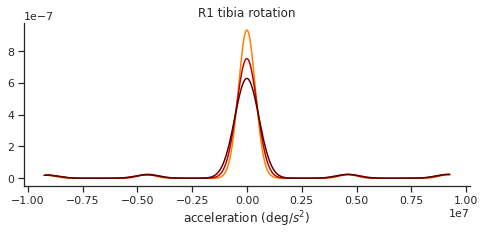

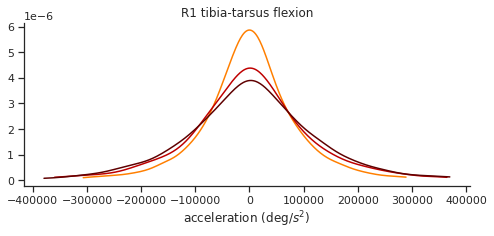

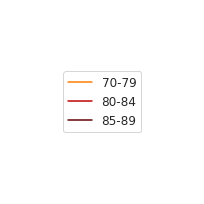

In [89]:
# plot angle distributions for each temperature treatment
sns.set_style('ticks')
temps = np.unique(data.temp)
legs = ['L1', 'R1']
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot', '_BC'])
              and some_contains(v, ['_d2'])
              and v[:2] in legs]

for i in range(len(angle_vars)): 

    fig = plt.figure(figsize = (9,2))
    plt.title(angle_vars[i][:2] + ' ' + titles[angle_vars[i][2:-3]])
    plt.xlabel('acceleration (deg/$s^2$)')
    colors = sns.color_palette('gist_heat_r', len(temps))

    for j in range(len(temps)):

        temp_data = data[data['temp'] == temps[j]]

        t1 = temp_data.iloc[0:][angle_vars[i]]
        t1 = t1[np.isfinite(t1)] # ignores nans 
        if len(t1) <= 1: 
            continue        

        kernel_t1 = stats.gaussian_kde(t1)    
        t1 = np.linspace(np.percentile(t1, 1), np.percentile(t1, 99), 500)
        height_t1 = kernel_t1.pdf(t1)                       
        plt.plot(t1, height_t1, label = temp_legend[temps[j]], color = colors[j])
    
    ax = plt.gca()
    hs, ls = ax.get_legend_handles_labels()
    plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
    sns.despine()
    plt.show()

fig = plt.figure(figsize = (3,3))
plt.legend(handles = hs, labels = ls, loc = 'center', fontsize = 12)
plt.axis('off')
plt.tight_layout()
plt.show()   

In [103]:
def get_freqs(data, fps, thresh = None, dist = None):
    
    data = data[np.isfinite(data)]
    idxs, props = signal.find_peaks(data, height = thresh, distance = dist)
    intervals = np.diff(idxs) / fps # in seconds
    if len(idxs) <= 1: 
        freqs = 1 / np.array([len(data)])
    else: 
        freqs = 1 / intervals
    
    freq_data = np.zeros(len(data))
    if len(intervals) == 0:
        freq_data = [freqs[0]]*len(data)
    else:
        freq_data[:idxs[0]] = freqs[0]
        freq_data[idxs[-1]:] = freqs[-1]
        if len(freqs) > 1:
            for i in range(len(freqs)):
                freq_data[idxs[i]:idxs[i+1]] = freqs[i]
    return freq_data

In [104]:
dist = 15
fps = 300
data = data.reset_index(drop = True)
bout_numbers = np.unique(data.behavior_bout)
angle_vars = np.unique([v for v in data.columns
              if some_contains(v, ['_BC', '_flex', '_rot', '_abduct'])
              and not some_contains(v, ['_d1', '_d2', '_freq', '_range', 'fictrac'])])
frequency = np.zeros(len(data))

for angle in angle_vars:
    
    for j in range(len(bout_numbers)):  
        bout_data = data[data.behavior_bout == bout_numbers[j]]
        freq_data = get_freqs(bout_data[angle], fps, dist = dist)
        frequency[bout_data.index] = freq_data
    
    data[angle + '_freq'] = frequency
    

In [108]:
# plot frequency for each joint averaged across all bouts and scatter 
# points around them 
angle_types_names = ['abduction', 'flexion', 'rotation']
angle_vars = [v for v in data.columns
              if some_contains(v, ['_flex', '_abduct', '_rot', '_BC'])
              and some_contains(v, ['_freq'])
              and v[:2] in legs]
sns.set_style('ticks')
scat = True
temps = np.unique(data.temps)
dists = np.array([15, 15, 15])

#cmap = plt.get_cmap('Spectral')
# colors = [cmap(i/(n-0.9999)) for i in range(8)] 

for i in range(len(angle_vars)):
    
    ang_names = [angle_vars[i] + ' (' + temp_legend[t] + ')' for t in temp_legend.keys()]
    fig = plt.figure(figsize = (8,4))
    plt.title('Average grooming frequency of ' + angle_vars[i] + ' angles', fontsize = 14)
    plt.xlabel('Joint', fontsize = 14)
    plt.ylabel('Frequency (Hz)', fontsize = 14) 
    colors = sns.color_palette('gist_heat_r', len(temps))
    ax = plt.gca()
    
    for j in range(len(temps)):
    
        temp_data = data[data.temp == temps[j]]
        mean = np.nanmean(temp_data[angle_vars[i]])
        stderr_freq = np.nanstd(temp_data[angle_vars[i]])

            
#             k = j + 1
#             sc = 0
#             if scat:
#                 sc = 0.5*np.random.rand(mean.shape[0]) - 0.75 
#             else: 
#                 sc = -0.5
#             plt.scatter(np.ones(mean.shape[0]) + j + sc, mean[:, j], s = 2, color = colors[j])
#             m = mean_freq[j]
#             x_b = j + 0.5
#             x_t = (j + 1)
#             ax.axhline(y = m, xmin = j/n + 0.02, xmax = k/n - 0.02, color = colors[j])
#             ax.errorbar(j + 0.5, mean_freq[j], yerr = stderr_freq[j], fmt = 'none', capsize = 5, color = colors[j])
#             plt.xlim([0, n])
#             plt.ylim([0, 26])
        # ax.errorbar(np.arange(0.5, n + 0.5, 1), mean_int, yerr = stderr_int, fmt = 'none', capsize = 5)

    plt.xticks(np.arange(0.5, (len(ang_names)), 1), [ang_names[n] for n in range(len(ang_names))])
    sns.despine()
    # plt.savefig(r'/media/turritopsis/katie/grooming/figures/grooming_freq/grooming_freq_' + angle_types_names[i] + '.png', bbox_inches = 'tight') 
    plt.show()

,date,folder_1,filename,fnum,flyid,L1_BC,L2_BC,L3_BC,R1_BC,R2_BC,...,R2D_flex_freq,R2_BC_freq,R3A_abduct_freq,R3A_flex_freq,R3A_rot_freq,R3B_flex_freq,R3B_rot_freq,R3C_flex_freq,R3C_rot_freq,R3D_flex_freq
26384,4.8.21,Fly 4_1,04082021_fly4_1 R3,1657,4.8.21 Fly 4_1,69.217542,60.633626,72.683934,94.836759,110.555475,...,15.0,14.285714,11.538462,8.333333,15.0,8.823529,15.789474,9.677419,12.00,12.500000
26385,4.8.21,Fly 4_1,04082021_fly4_1 R3,1658,4.8.21 Fly 4_1,69.284829,60.674696,72.685250,94.319624,110.250245,...,15.0,14.285714,11.538462,8.333333,15.0,8.823529,15.789474,9.677419,12.00,12.500000
26386,4.8.21,Fly 4_1,04082021_fly4_1 R3,1659,4.8.21 Fly 4_1,69.371176,60.788706,72.853894,93.969971,110.129243,...,15.0,14.285714,11.538462,8.333333,15.0,8.823529,15.789474,9.677419,12.00,12.500000
26387,4.8.21,Fly 4_1,04082021_fly4_1 R3,1660,4.8.21 Fly 4_1,69.252867,60.857919,72.979866,93.721512,110.135948,...,15.0,14.285714,11.538462,8.333333,15.0,8.823529,15.789474,9.677419,12.00,12.500000
26388,4.8.21,Fly 4_1,04082021_fly4_1 R3,1661,4.8.21 Fly 4_1,68.933616,60.827232,72.967724,93.537489,110.276174,...,15.0,14.285714,11.538462,8.333333,15.0,8.823529,15.789474,9.677419,12.00,12.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26462,4.8.21,Fly 4_1,04082021_fly4_1 R3,1735,4.8.21 Fly 4_1,68.509673,60.694884,70.073344,94.275470,111.487362,...,15.0,17.647059,16.666667,12.000000,20.0,11.538462,13.636364,15.789474,18.75,14.285714
26463,4.8.21,Fly 4_1,04082021_fly4_1 R3,1736,4.8.21 Fly 4_1,68.582315,60.719678,69.359293,94.291239,111.312529,...,15.0,17.647059,16.666667,12.000000,20.0,11.538462,13.636364,15.789474,18.75,14.285714
26464,4.8.21,Fly 4_1,04082021_fly4_1 R3,1737,4.8.21 Fly 4_1,68.668819,60.639594,68.386119,94.354686,111.218384,...,15.0,17.647059,16.666667,12.000000,20.0,11.538462,13.636364,15.789474,18.75,14.285714
26465,4.8.21,Fly 4_1,04082021_fly4_1 R3,1738,4.8.21 Fly 4_1,68.843704,60.585912,67.632556,94.310253,111.001928,...,15.0,17.647059,16.666667,12.000000,20.0,11.538462,13.636364,15.789474,18.75,14.285714


In [119]:
data.groupby('temp').mean()

,fnum,L1_BC,L2_BC,L3_BC,R1_BC,R2_BC,R3_BC,L1A_flex,L1A_rot,L1A_abduct,...,R2_BC_freq,R3A_abduct_freq,R3A_flex_freq,R3A_rot_freq,R3B_flex_freq,R3B_rot_freq,R3C_flex_freq,R3C_rot_freq,R3D_flex_freq,R3_BC_freq
temp,,,,,,,,,,,,,,,,,,,,,
0,5521.702600,68.899729,63.062153,72.307739,94.997033,110.802350,121.551272,22.398940,-106.202913,149.352907,...,12.759365,12.783991,12.525721,13.185180,12.610938,13.014134,12.815613,13.523080,13.347108,13.011004
1,5547.180711,69.559379,65.428460,76.740922,92.356376,108.631797,118.296319,22.442797,-112.091094,149.710848,...,13.226439,12.862254,13.124277,13.096728,13.163761,13.048448,13.512337,13.655698,13.384849,12.790692
2,5156.154380,67.809163,62.396996,72.529681,94.641567,112.206346,119.681111,23.846721,-114.114387,149.857428,...,12.689231,13.341833,12.705867,12.556384,12.106129,13.025367,12.663115,13.515250,13.155538,12.603723
